### Notes sur l'article de QAOA: 

QAOA vise à trouver l'énergie fondamentale soit la plus petite énergie par une fonction d'onde paramétrée, on cherche la valeur du paramètre qui va minimiser la fonction. 
Pour un état $|\psi\rangle$ donné, une énergie fondamentale $E_0$, on aurait: $$E_0 \leq \frac{\langle\psi | H |\psi \rangle}{\langle\psi | \psi \rangle}$$

On prend une entrée et on génère un ket paramétré en appliquant un opérateur paramétré, avec ce ket paramétré, on peut calculer la moyenne de l'hamiltonien à multiple reprises et trouver le paramètre qui va minimiser cette valeur moyenne. 
$$\lambda = min_\theta \langle\psi_0 |U^\dag(\theta) H U(\theta)|\psi_0\rangle$$
$$\lambda_{min} = E_0 \approx \langle\psi(\theta^*) | H |\psi(\theta^*)\rangle$$


#### Fonction objective et $m$ contraintes: 

On veut optimiser une fonction coût: $C(x)$ où $x$ fait partie du domaine $d$. En quantique, on peut représenter le tout comme un opérateur $H_C$ agissant sur un ket 
$ |z\rangle$, où $z$ est une chaîne de bits appartenant à l'ensemble $\{ 0,1\}^{\otimes n }$. 

$$H_C|z\rangle = \sum_{k=1}^{m'} C_k|z\rangle = C|z\rangle $$

Ici, $C_k$ est associée à une contrainte, que, lorsque respectée, donne la valeur de 1 à C, 0 sinon. 
On définit une fonction coût pouvant être mappé à un Hamiltonien. Il faut considérer les contraintes du point de départ, de fin ainsi que les points intermédiaires de manière à avoir un chemin plus court. En ajoutant une valeur plus ou moins importante au M, on augmente la valeur de la fonction qu'on cherche à maximiser. On veut que C soit le plus grand possible de manière à garder le chemin avec les poids les plus grands (plus grande probabilité de diffusion). Ensuite, si une contrainte n'est pas respectée, M sera non nul ce qui viendra diminuer la valeur de F qu'on cherche à maximiser (M > 0).  

Il s'agit de l'Hamiltonien (temporaire) donné par : $$F = C - M (\sum_{j=1}^n x_{sj} -1 )²  - M (\sum_{i=1}^n x_{id} -1 )²- M \sum_{k \in V, k \neq s, d}^n (\sum_{i=1}^n x_{ik} - \sum_{j=1}^n x_{kj} )²$$


On sait que C est le coût du plus court chemin, $$C = \sum_{i,j} w_{ij} x_{ij}$$

Dans notre cas, nos poids sont donnés par : 

$$w_{ij} = w_{ji} = P_{mat}(i) \cdot P_{mat}(j) \cdot [P_{Diff}(i, r_{ij}) + P_{Diff}(j, r_{ji})]$$

Dans reconst.py, on peut voir  : 

```
w = sf[start_x, start_y, dir_id] + sf[conn_x, conn_y, dir_id] 
```

#### Librairies : 

In [13]:
import numpy as np 
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw

#### Graphe pour tester les noeuds connectés à deux autres en triangle: 
#### Graph to test connected nodes in triangular fashion :

Adjacency matrix: 
 [[0.         0.15725264 0.398374  ]
 [0.15725264 0.         0.297635  ]
 [0.398374   0.297635   0.        ]]

 1D array of adjacency matrix: 
 [0.0, 0.1572526358050491, 0.398374, 0.1572526358050491, 0.0, 0.297635, 0.398374, 0.297635, 0.0]


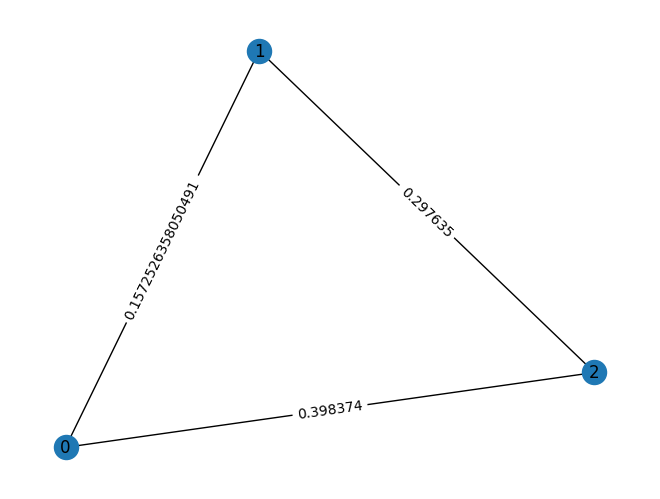

In [21]:
# We can try a test adjacency matrix (symetric with a zero element on diagonal) where each node is connected to two others: 
nodes = 3 
adj_mat = np.array([[0.0, 1.0 ,1.0],[ 1.0, 0.0, 0.0],[ 1.0 ,0.0, 0.0]])

# normalise to 0.5: 
random_num_max_05 = np.random.default_rng().random()/2
adj_mat *= random_num_max_05
adj_mat[0,2] = 0.398374 
adj_mat[2,0] = adj_mat[0,2]
adj_mat[1,2] = 0.297635
adj_mat[2,1] = adj_mat[1,2]
print(f'Adjacency matrix: \n {adj_mat}') 

# read matrix from left to right, top to bottom : 
one_D_array_connections = adj_mat.flatten()
one_D_array_connections = list(one_D_array_connections)
print(f'\n 1D array of adjacency matrix: \n {one_D_array_connections}') 
# With the adjacency matrix, we can build a graph: 
graph = rx.PyGraph()
nodes_list = graph.add_nodes_from((range(nodes)))
graph.add_edges_from([(0, 1, adj_mat[0,1]), (1, 2, adj_mat[1,2]), (2, 0, adj_mat[2,0])])

draw(graph, with_labels=True, edge_labels=str) # type: ignore

#### Graphe pour tester l'algorithme de QAOA: 
#### Graph to test QAOA algorithm: 

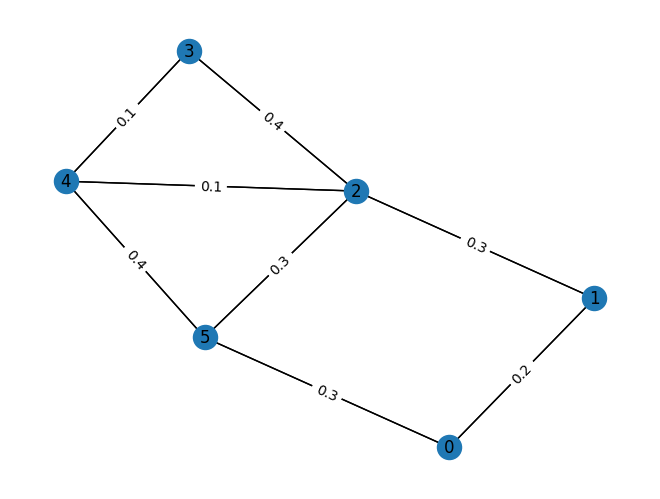

In [20]:
# Let's create a bigger graph with more intersections : 
mat_adj = np.array([[0.0, 0.2, 0.0, 0.0, 0.0, 0.3],
                    [0.2, 0.0, 0.3, 0.0, 0.0, 0.0],
                    [0.0, 0.3, 0.0, 0.4, 0.1, 0.3],
                    [0.0, 0.0, 0.4, 0.0, 0.1, 0.0],
                    [0.0, 0.0, 0.1, 0.1, 0.0, 0.4],
                    [0.3, 0.0, 0.3, 0.0, 0.4, 0.0]])

# With the adjacency matrix, we can build a graph : 
graph_cross = rx.PyGraph()
num_nodes_cross_graph = 6 
nodes_list = graph_cross.add_nodes_from((range(num_nodes_cross_graph)))

# Add edges : 
edges = []
for i in range(num_nodes_cross_graph):
    for j in range(num_nodes_cross_graph):
        if mat_adj[i, j] != 0:
            edges.append((i, j, mat_adj[i, j]))
            
# print(edges)
graph_cross.add_edges_from(edges)
draw(graph_cross, with_labels=True, edge_labels=str) # type: ignore

#### Je définis mon point de départ comme étant le noeud 0 et mon point final étant le noeud 5. 

In [22]:
print(edges)

[(0, 1, 0.2), (0, 5, 0.3), (1, 0, 0.2), (1, 2, 0.3), (2, 1, 0.3), (2, 3, 0.4), (2, 4, 0.1), (2, 5, 0.3), (3, 2, 0.4), (3, 4, 0.1), (4, 2, 0.1), (4, 3, 0.1), (4, 5, 0.4), (5, 0, 0.3), (5, 2, 0.3), (5, 4, 0.4)]


In [6]:

# Cost function : 
def shortest_path_cost():
    C = 1 
    return C

# Constraints :-2
# Start point constraint : 
def one_starting_point():
    x_sj  = 1 
    start_cond = 1 
    
    start_cond_squared = start_cond**2 
    return start_cond_squared  

# End point constraint : 
def one_ending_point():
    x_id  = 1 
    end_cond = 1 
    
    end_cond_squared = end_cond**2 
    return end_cond_squared  

# Intermediate points constraints : 
def one_intermediate_point():
    x_ik  = 1
    x_kj = 1  
    inter_cond = 1 
    
    inter_cond_squared = inter_cond**2 
    sum_inter_cond_squared = 1 * inter_cond_squared 
    return sum_inter_cond_squared  

# Objective function : 
def objective_function(M):
    return shortest_path_cost() - M * one_starting_point() - M * one_ending_point() - M * one_intermediate_point() 

objective_function(1)

-2